# Notebook 2: Consultar datos desde MySQL e cargalos en Cassandra.

En este cuaderno se consultarán los datos almacenados anteriormente en la base de datos de MySQL (mirar y ejecutar Notebook 1). Después de consultarlos se pasarán a un keyspace de Cassandra.

In [34]:
import pandas as pd
from sqlalchemy import create_engine

# CONEXIÓN A MYSQL
mysql_user = "user"
mysql_password = "password"
mysql_host = "127.0.0.1"
mysql_port = "3306"
mysql_db = "testdb"
table_name = "mi_tabla"

engine = create_engine(f"mysql+mysqlconnector://{mysql_user}:{mysql_password}@{mysql_host}:{mysql_port}/{mysql_db}")

# GUARDAMOS LOS DATOS SACADOS DE LA TABLA DE MYSQL EN UN DATAFRAME DE PANDAS
df = pd.read_sql(f"SELECT * FROM {table_name}", engine)

In [35]:
from cassandra.cluster import Cluster

# CONEXIÓN AL CLUSTER DE CASSANDRA
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

# CREACIÓN DEL KEYSPACE SI NO EXISTE
session.execute("""
CREATE KEYSPACE IF NOT EXISTS netflix_keyspace
WITH REPLICATION = { 'class': 'SimpleStrategy', 'replication_factor': 1 }
""")

# SE SELECCIONA LA KEYSPACE
session.set_keyspace('netflix_keyspace')

# CREAR LA TABLA SI NO EXISTE
session.execute("""
CREATE TABLE IF NOT EXISTS netflix_table (
    show_id TEXT PRIMARY KEY,
    type TEXT,
    title TEXT,
    director TEXT,
    cast TEXT,
    country TEXT,
    date_added TEXT,
    release_year INT,
    rating TEXT,
    duration TEXT,
    listed_in TEXT,
    description TEXT
)
""")

In [36]:
from cassandra.query import PreparedStatement

# PREPARACIÓN DE LA QUERY PARA INSERTAR LOS DATOS ALMACENADOS EN EL DATAFRAME SACADO DE MYSQL. SE APLICAN 
# LOS INTERROGANTES PARA PASARLE LA INFORMACIÓN ALMACENADA EN EL DATAFRAME.
insert_query = session.prepare("""
INSERT INTO netflix_table (
    show_id, type, title, director, cast, country,
    date_added, release_year, rating, duration,
    listed_in, description
) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
""")

# SE LE AÑADEN LOS DATOS A LA QUERY HACIENDO UNA ITERACIÓN POR FILA DEL DATASET.
for _, row in df.iterrows():
    session.execute(insert_query, (
        row['show_id'], row['type'], row['title'], row['director'],
        row['cast'], row['country'], row['date_added'], row['release_year'],
        row['rating'], row['duration'], row['listed_in'], row['description']
    ))

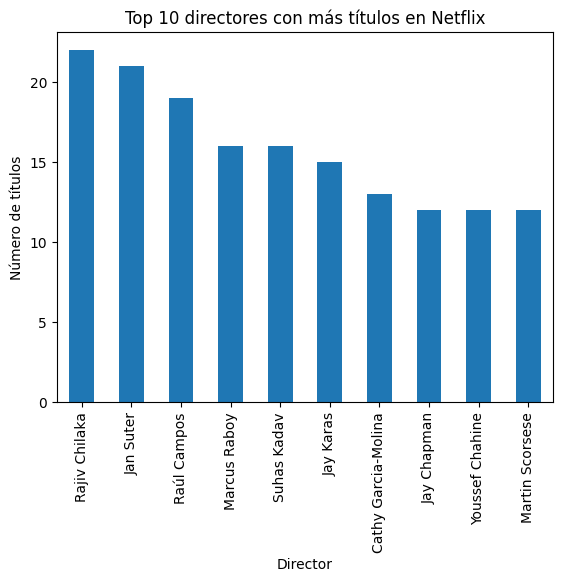

In [37]:
import matplotlib.pyplot as plt

# SE GUARDAN LOS DATOS DE LA TABLA EN UN DATAFRAME DE PANDAS PARA CONSULTARLOS MEJOR.
query = "SELECT * FROM netflix_table"
rows = session.execute(query)
netflix_cassandra = pd.DataFrame(rows)

# SE FILTRAN LOS DIRECTORES Y LUEGO SE GUARDAN LOS 10 QUE MÁS TÍTULOS TIENEN.
directores = netflix_cassandra['director'].dropna().str.split(',').explode().str.strip()
top_directores = directores.value_counts().head(10)

# GRÁFICA PARA MOSTRAR LOS DIRECTORES GUARDADOS EN UN GRÁFICO DE BARRAS.
top_directores.plot(kind='bar')
plt.title("Top 10 directores con más títulos en Netflix")
plt.xlabel("Director")
plt.ylabel("Número de títulos")
plt.show()

In [38]:
# ¡¡IMPORTANTE CERRAR EL CLUSTER DESPUÉS DE TRABAJAR CON ÉL!!
cluster.shutdown()